# Training Capsule Network on CIFAR10

Harder than MNIST!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import optim

from datasets import get_cifar10_dataset, get_data_loader
from utils import *

from capsnet import *

Files already downloaded and verified
Files already downloaded and verified


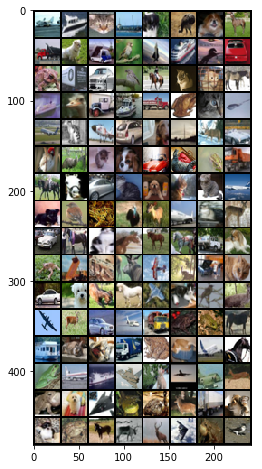

In [3]:
trainset, testset = get_cifar10_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [25]:
net = CapsuleNetwork(img_colors=3, p_caps=64).cuda()
decoder = CapsuleDecoder(img_colors=3, reconstruction=True, mask_incorrect=True).cuda()
class CapsModel(nn.Module):
    def __init__(self, net, decoder):
        super().__init__()
        self.net = net
        self.decoder = decoder
    
    def forward(self, x, y=None):
        d_caps = self.net(x)
        probs, reconstructions = self.decoder(d_caps, y)
        return probs, reconstructions
caps_model = CapsModel(net, decoder)

print(count_params(net))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.001)
caps_optimizer = optim.Adam(caps_model.parameters(), lr=5e-3)
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

13628928
16647472


In [26]:
MODEL_PATH = 'capsnet_cifar.pth.tar'

In [27]:
caps_trainer.load_checkpoint(MODEL_PATH)

In [31]:
caps_trainer.save_checkpoint(MODEL_PATH)

In [32]:
caps_trainer.run(epochs=20)

[*] Training for 20 epochs
[*] Batch 0, Loss: 73.868, Acc: 0.703
[*] Batch 50, Loss: 73.827, Acc: 0.711
[*] Batch 100, Loss: 72.808, Acc: 0.672
[*] Batch 150, Loss: 73.752, Acc: 0.695
[*] Batch 200, Loss: 73.643, Acc: 0.664
[*] Batch 250, Loss: 74.574, Acc: 0.625
[*] Batch 300, Loss: 73.144, Acc: 0.680
[*] Batch 350, Loss: 74.233, Acc: 0.688
[*] Batch 0, Loss: 75.343, Acc: 0.617
[*] Batch 50, Loss: 75.028, Acc: 0.594
[*] Epoch 1, TrnLoss: 74.182, TrnAcc: 0.642, TstLoss: 74.301, TstAcc: 0.611
[*] Batch 0, Loss: 75.014, Acc: 0.602
[*] Batch 50, Loss: 72.885, Acc: 0.703
[*] Batch 100, Loss: 75.068, Acc: 0.656
[*] Batch 150, Loss: 75.154, Acc: 0.633
[*] Batch 200, Loss: 73.746, Acc: 0.672
[*] Batch 250, Loss: 73.681, Acc: 0.695
[*] Batch 300, Loss: 73.161, Acc: 0.664
[*] Batch 350, Loss: 72.669, Acc: 0.695
[*] Batch 0, Loss: 74.151, Acc: 0.680
[*] Batch 50, Loss: 74.922, Acc: 0.586
[*] Epoch 2, TrnLoss: 74.068, TrnAcc: 0.648, TstLoss: 73.661, TstAcc: 0.635
[*] Batch 0, Loss: 74.505, Acc: 0

KeyboardInterrupt: 

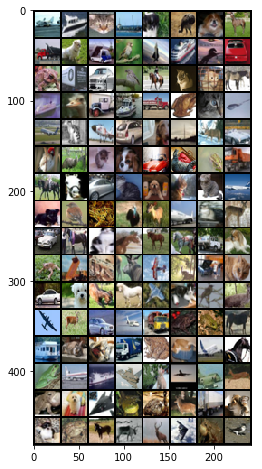

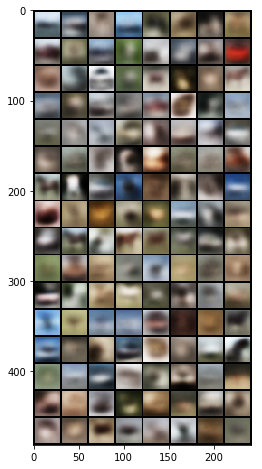

In [33]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data)